##### Copyright 2024 Google LLC.

# JS CODE


In [ ]:
;;<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Re-entry Demise Simulator</title>
    <script src="https://cdn.tailwindcss.com"></script>
    <style>
        @import url('https://fonts.googleapis.com/css2?family=Inter:wght@400;500;700&display=swap');
        body {
            font-family: 'Inter', sans-serif;
            background-color: #0d1117;
            color: #c9d1d9;
        }
        .container {
            max-width: 960px;
            margin: 0 auto;
            padding: 2rem;
        }
        .card {
            background-color: #161b22;
            border-radius: 12px;
            padding: 2rem;
            box-shadow: 0 4px 6px rgba(0, 0, 0, 0.1);
        }
        .input-group label {
            color: #8b949e;
        }
        .table-container {
            overflow-x: auto;
        }
        th, td {
            border: 1px solid #30363d;
            padding: 0.75rem;
            text-align: left;
        }
        th {
            background-color: #21262d;
            font-weight: 600;
        }
    </style>
</head>
<body class="bg-[#0d1117] text-[#c9d1d9]">
    <div class="container py-8">
        <div class="card">
            <h1 class="text-3xl font-bold mb-6 text-center text-[#58a6ff]">Space Debris Re-entry Simulator</h1>
            <p class="text-center mb-6 text-[#8b949e]">
                This tool simulates the demise of space debris during atmospheric re-entry. It calculates the remaining mass for various materials based on their thermal properties. Please upload a CSV file with debris data to begin.
            </p>
            <div class="flex flex-col items-center space-y-4">
                <div class="input-group w-full max-w-sm">
                    <label for="file-input" class="block text-sm font-medium mb-1">Upload Debris Data (CSV):</label>
                    <input type="file" id="file-input" accept=".csv" class="w-full text-sm text-[#8b949e] file:mr-4 file:py-2 file:px-4 file:rounded-full file:border-0 file:text-sm file:font-semibold file:bg-[#58a6ff] file:text-white hover:file:bg-[#79b8ff] cursor-pointer rounded-lg p-2 border border-[#30363d]">
                </div>
                <div id="loading-spinner" class="hidden flex items-center space-x-2">
                    <svg class="animate-spin h-5 w-5 text-[#58a6ff]" xmlns="http://www.w3.org/2000/svg" fill="none" viewBox="0 0 24 24">
                        <circle class="opacity-25" cx="12" cy="12" r="10" stroke="currentColor" stroke-width="4"></circle>
                        <path class="opacity-75" fill="currentColor" d="M4 12a8 8 0 018-8V0C5.373 0 0 5.373 0 12h4zm2 5.291A7.962 7.962 0 014 12H0c0 3.042 1.135 5.824 3 7.938l3-2.647z"></path>
                    </svg>
                    <span class="text-sm">Simulating re-entry...</span>
                </div>
            </div>
        </div>

        <div id="results-container" class="mt-8 hidden">
            <div class="card mb-8">
                <h2 class="text-2xl font-bold mb-4 text-[#58a6ff]">Simulation Summary</h2>
                <div class="table-container">
                    <table class="w-full text-sm rounded-lg overflow-hidden">
                        <thead>
                            <tr>
                                <th class="py-2 px-3">Material</th>
                                <th class="py-2 px-3">Total Initial Mass (kg)</th>
                                <th class="py-2 px-3">Total Final Mass (kg)</th>
                                <th class="py-2 px-3">Survival Rate (%)</th>
                            </tr>
                        </thead>
                        <tbody id="summary-table-body">
                            <!-- Summary data will be inserted here -->
                        </tbody>
                    </table>
                </div>
            </div>

            <div class="card">
                <h2 class="text-2xl font-bold mb-4 text-[#58a6ff]">Detailed Results</h2>
                <div class="table-container">
                    <table class="w-full text-sm rounded-lg overflow-hidden">
                        <thead>
                            <tr>
                                <th class="py-2 px-3">Debris ID</th>
                                <th class="py-2 px-3">Initial Mass (kg)</th>
                                <th class="py-2 px-3">Final Mass (kg)</th>
                                <th class="py-2 px-3">Survival Rate (%)</th>
                                <th class="py-2 px-3">Leftover Copper (kg)</th>
                                <th class="py-2 px-3">Leftover Carbon Fiber (kg)</th>
                                <th class="py-2 px-3">Leftover Gold (kg)</th>
                                <th class="py-2 px-3">Leftover Aluminum (kg)</th>
                                <th class="py-2 px-3">Leftover Silicon (kg)</th>
                            </tr>
                        </thead>
                        <tbody id="results-table-body">
                            <!-- Detailed results will be inserted here -->
                        </tbody>
                    </table>
                </div>
            </div>
        </div>
    </div>

    <script>
        document.addEventListener('DOMContentLoaded', () => {
            const fileInput = document.getElementById('file-input');
            const loadingSpinner = document.getElementById('loading-spinner');
            const resultsContainer = document.getElementById('results-container');
            const resultsTableBody = document.getElementById('results-table-body');
            const summaryTableBody = document.getElementById('summary-table-body');

            // Simplified thermal properties for re-entry calculation
            // Based on Fay-Riddell equation and material properties
            // Values are theoretical and simplified for demonstration
            const materialProperties = {
                'copper': { heatOfAblation: 4.8e6, dragCoefficient: 0.5, density: 8960 },
                'carbon_fiber': { heatOfAblation: 6.0e7, dragCoefficient: 1.2, density: 1750 },
                'gold': { heatOfAblation: 1.2e6, dragCoefficient: 0.4, density: 19320 },
                'aluminium': { heatOfAblation: 1.0e7, dragCoefficient: 0.8, density: 2700 },
                'silicon': { heatOfAblation: 1.5e7, dragCoefficient: 0.9, density: 2330 }
            };

            fileInput.addEventListener('change', (event) => {
                const file = event.target.files[0];
                if (!file) return;

                loadingSpinner.classList.remove('hidden');
                resultsContainer.classList.add('hidden');
                resultsTableBody.innerHTML = '';
                summaryTableBody.innerHTML = '';

                const reader = new FileReader();
                reader.onload = (e) => {
                    const csv = e.target.result;
                    const data = parseCSV(csv);
                    processDebrisData(data);
                };
                reader.readAsText(file);
            });

            function parseCSV(csvText) {
                const lines = csvText.split('\n').filter(line => line.trim() !== '');
                const headers = lines[0].split(',').map(header => header.trim().replace(/\s+/g, '_').toLowerCase());
                const data = [];
                for (let i = 1; i < lines.length; i++) {
                    const values = lines[i].split(',');
                    if (values.length === headers.length) {
                        const obj = {};
                        headers.forEach((header, index) => {
                            let value = values[index].trim();
                            if (!isNaN(value) && value !== '') {
                                obj[header] = parseFloat(value);
                            } else {
                                obj[header] = value;
                            }
                        });
                        data.push(obj);
                    }
                }
                return data;
            }

            function processDebrisData(data) {
                const allMaterials = ['copper', 'carbon_fiber', 'gold', 'aluminium', 'silicon'];
                const summary = allMaterials.reduce((acc, material) => {
                    acc[material] = { initial: 0, final: 0 };
                    return acc;
                }, {});

                const simulatedData = data.map(debris => {
                    const { total_mass_kg, speed_mps, altitude_m, ...materials } = debris;
                    let totalInitialMass = total_mass_kg;

                    // Simplified heat input calculation (Fay-Riddell approximation)
                    // This is a heuristic and not a precise physical model
                    const heatingRate = 0.5 * Math.pow(speed_mps, 3) * Math.pow(altitude_m / 1000, -2);
                    const totalEnergyInput = heatingRate * debris.time_to_fall_s;

                    let remainingMass = {};
                    let totalFinalMass = 0;

                    allMaterials.forEach(material => {
                        const amount = debris[`amount_of_${material}`] || 0;
                        summary[material].initial += amount;

                        const specificEnergy = materialProperties[material].heatOfAblation;
                        const energyToDemise = amount * specificEnergy;

                        let finalAmount;
                        if (totalEnergyInput > energyToDemise) {
                            finalAmount = 0;
                        } else {
                            finalAmount = amount - (totalEnergyInput / specificEnergy);
                        }
                        if (finalAmount < 0) finalAmount = 0;

                        remainingMass[material] = finalAmount;
                        totalFinalMass += finalAmount;
                        summary[material].final += finalAmount;
                    });

                    const survivalRate = totalInitialMass > 0 ? (totalFinalMass / totalInitialMass) * 100 : 0;

                    return {
                        debris_id: debris.debris_id,
                        totalInitialMass: totalInitialMass,
                        totalFinalMass: totalFinalMass,
                        survivalRate: survivalRate,
                        remainingMass: remainingMass
                    };
                });

                renderResults(simulatedData, summary);
            }

            function renderResults(simulatedData, summary) {
                resultsTableBody.innerHTML = '';
                summaryTableBody.innerHTML = '';

                simulatedData.forEach(debris => {
                    const row = `
                        <tr>
                            <td>${debris.debris_id}</td>
                            <td>${debris.totalInitialMass.toFixed(2)}</td>
                            <td>${debris.totalFinalMass.toFixed(2)}</td>
                            <td>${debris.survivalRate.toFixed(2)}%</td>
                            <td>${debris.remainingMass.copper.toFixed(2)}</td>
                            <td>${debris.remainingMass.carbon_fiber.toFixed(2)}</td>
                            <td>${debris.remainingMass.gold.toFixed(2)}</td>
                            <td>${debris.remainingMass.aluminium.toFixed(2)}</td>
                            <td>${debris.remainingMass.silicon.toFixed(2)}</td>
                        </tr>
                    `;
                    resultsTableBody.innerHTML += row;
                });

                const allMaterials = ['copper', 'carbon_fiber', 'gold', 'aluminium', 'silicon'];
                allMaterials.forEach(material => {
                    const initial = summary[material].initial;
                    const final = summary[material].final;
                    const survivalRate = initial > 0 ? (final / initial) * 100 : 0;
                    const row = `
                        <tr>
                            <td>${material.replace('_', ' ').charAt(0).toUpperCase() + material.replace('_', ' ').slice(1)}</td>
                            <td>${initial.toFixed(2)}</td>
                            <td>${final.toFixed(2)}</td>
                            <td>${survivalRate.toFixed(2)}%</td>
                        </tr>
                    `;
                    summaryTableBody.innerHTML += row;
                });

                loadingSpinner.classList.add('hidden');
                resultsContainer.classList.remove('hidden');
            }
        });
    </script>
</body>
</html>


SyntaxError: invalid decimal literal (ipython-input-1762614786.py, line 16)

In [ ]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Gemini API Python quickstart

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/tutorials/quickstart_colab"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on Google AI</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/tutorials/quickstart_colab.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/tutorials/quickstart_colab.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This tutorial shows you how to get started with the Gemini API using the Python SDK.

## Prerequisites

You can run this tutorial in Google Colab, which doesn't require additional environment configuration.

Alternatively, to complete this quickstart locally, see the Python guidance in [Get started with the Gemini API](https://ai.google.dev/tutorials/quickstart).

## Install the SDK

The Python SDK for the Gemini API is contained in the [`google-generativeai`](https://pypi.org/project/google-generativeai/) package. Install the dependency using pip:

In [ ]:
!pip install -q -U google-generativeai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.4/137.4 kB 1.1 MB/s eta 0:00:00


## Set up your API key

To use the Gemini API, you'll need an API key. If you don't already have one, create a key in Google AI Studio.

<a class="button" href="https://aistudio.google.com/app/apikey" target="_blank" rel="noopener noreferrer">Get an API key</a>

In Colab, add the key to the secrets manager under the "🔑" in the left panel. Give it the name `GOOGLE_API_KEY`. Then pass the key to the SDK:

In [ ]:
# Import the Python SDK
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata

# WARNING: The provided key is likely NOT a valid Google Gemini API key and will cause errors.
# Replacing the key fetched from userdata with the provided key as requested by the user.
GOOGLE_API_KEY='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'

genai.configure(api_key=GOOGLE_API_KEY)

## Initialize the Generative Model

Before you can make any API calls, you need to initialize the Generative Model.

In [ ]:
model = genai.GenerativeModel('gemini-1.5-pro-latest')

## Generate text

In [ ]:
response = model.generate_content("Describe degradation of aluminium on its entry into the earth's atmosphere from space")
print(response.text)

The degradation of aluminum upon atmospheric entry from space is a complex process primarily driven by **oxidation** and **ablation**.  It's drastically different from the relatively slow corrosion aluminum experiences on Earth's surface.

Here's a breakdown:

* **High-Velocity Heating:**  As an aluminum object enters the atmosphere at hypersonic speeds, friction with the air molecules causes intense heating.  The surface temperature can reach thousands of degrees Celsius.

* **Oxidation:** At these temperatures, aluminum reacts vigorously with atmospheric oxygen.  This forms aluminum oxide (Al₂O₃), a very stable ceramic material.  This oxidation process consumes the aluminum, reducing the mass of the object.

* **Ablation:**  The intense heat also causes the molten aluminum oxide and any remaining aluminum to be physically stripped away from the surface.  This process, called ablation, is a combination of melting, vaporization, and aerodynamic shear forces removing the molten material

In [ ]:
for m in genai.list_models():
  if 'generateContent' in m.supported_generation_methods:
    print(m.name)

models/gemini-1.5-pro-latest
models/gemini-1.5-pro-002
models/gemini-1.5-pro
models/gemini-1.5-flash-latest
models/gemini-1.5-flash
models/gemini-1.5-flash-002
models/gemini-1.5-flash-8b
models/gemini-1.5-flash-8b-001
models/gemini-1.5-flash-8b-latest
models/gemini-2.5-pro-preview-03-25
models/gemini-2.5-flash-preview-05-20
models/gemini-2.5-flash
models/gemini-2.5-flash-lite-preview-06-17
models/gemini-2.5-pro-preview-05-06
models/gemini-2.5-pro-preview-06-05
models/gemini-2.5-pro
models/gemini-2.0-flash-exp
models/gemini-2.0-flash
models/gemini-2.0-flash-001
models/gemini-2.0-flash-exp-image-generation
models/gemini-2.0-flash-lite-001
models/gemini-2.0-flash-lite
models/gemini-2.0-flash-preview-image-generation
models/gemini-2.0-flash-lite-preview-02-05
models/gemini-2.0-flash-lite-preview
models/gemini-2.0-pro-exp
models/gemini-2.0-pro-exp-02-05
models/gemini-exp-1206
models/gemini-2.0-flash-thinking-exp-01-21
models/gemini-2.0-flash-thinking-exp
models/gemini-2.0-flash-thinking-exp

Perplexity

In [ ]:
import google.generativeai as genai
# Used to securely store your API key
from google.colab import userdata

GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

## Integrate apis for shelf life

### Subtask:
Modify the code to call the identified API(s) to fetch real-time shelf life data for each material or suggested end product.


**Reasoning**:
Modify the code in cell 'fhh5xOllIFIh' to add a placeholder function for fetching real-time shelf life data and integrate this into the main loop and results DataFrame.



## Update data processing

### Subtask:
Adjust the data processing logic to incorporate the information retrieved from the new API calls into the results DataFrame.


**Reasoning**:
The subtask is to incorporate the information retrieved from the new API calls into the results DataFrame. I will review the existing code to ensure the placeholder API calls for end products and shelf life are integrated correctly into the results dictionary within the loop and that the fallback logic is in place.



## Update dashboard output

### Subtask:
Modify the display of the results DataFrame to include the real-time end products with descriptions and shelf life data.


## Handle api errors and limitations

### Subtask:
Implement error handling for the new API calls and consider potential limitations or costs associated with using these APIs.


**Reasoning**:
Add detailed error handling to the API calls for end products and shelf life, including specific exception types and informative messages, and add comments about API limitations.



In [ ]:
!pip install groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 kB 7.3 MB/s eta 0:00:00


## Set up groq api key

### Subtask:
Set up Groq API key using Colab Secrets.


Please enter the remaining mass (kg) for each material:
Aluminum (kg): 34
Copper (kg): 45
Carbon Fiber (kg): 56
Gold (kg): 67
Silicon (kg): 78

🚀 Real-Time Recycled Material Dashboard:



,Material,Remaining Mass (kg),Recovered Mass (kg),Live Price (USD/kg),Suggested End Products,Economic Value ($),Shelf Life (years)
0,Aluminum,34.0,27.20,2.69,"Based on the availability of recovered aluminum (approximately 27.20 kg), here's a list of possible end products:Aluminum Cans for Food or Beverages: Used for packaging and storage of food, drinks, and other household items, 12, 000 - 15, 000 200ml cans can be made from the recovered aluminum.Aluminum Foil: Used for wrapping and packaging of food items, cooking and baking, and other household purposes.Aluminum Baking Pans: Used for baking and cooking in ovens and on stovetops for cooking.Aluminum Piping: Used for industrial piping and plumbing due to its corrosion-resistance and lightweight properties.Aluminum Bicycle Frames: Used in bicycle production, reducing the weight of bikes while maintaining durability.Aluminum Alloy Engine Blocks: Used in automotive and aircraft engine construction due to their high heat conductivity, strength and light weight.Aluminum Siding: Used for exterior and interior wall cladding due to its durability and weather-resistance properties.Lightweight Aluminum Camping Gear: Used in manufacturing portable stoves, utensils, and other lightweight equipment.Aluminum Automotive Parts: Used in manufacturing car parts, including wheels, door panels and other functional components.Aluminum Airplane Skins: Used in aircraft production, helping reduce weight while maintaining structural integrity.Aluminum Window Frames: Used for constructing and installing windows in homes and buildings due to its durability and low maintenance.",73.17,18
1,Copper,45.0,33.75,10.00,"With 33.75 kg of recovered copper, here are some possible end products:Wire: Used in electrical transmission and distribution for residential, commercial, and industrial purposes.Electronics components: Integrated circuits, resistors, capacitors, and inductors in personal computers, smartphones, and other electronic devices.Alloys (Cu-Zn or Brass): Used in plumbing fixtures due to its corrosion resistance and durability.Alloys (Cu-Ni or Monel): Used in marine hardware, valves, and heat exchangers due to its resistance to corrosion and high-temperature applications.Coinage: Minted into currency, such as US pennies and Canadian coins.Electrical wire insulation: Used as an insulation material in electrical wires.Heat sinks: Used to dissipate heat from electronic components, such as CPUs and GPUs.Radiators and pipes: Used in heating and cooling systems.Switches and relays: Used in electrical control circuits.Semiconductors: Used in the production of integrated circuits and other electronic components.Copper foils: Used as a protective layer in various applications, including roofing, windows, and electrical circuits.Note: Prices of copper may influence the selection and demand for these products depending on markets at the given time.",337.50,22
2,Carbon Fiber,56.0,33.60,50.00,"With 33.60 kg of recovered Carbon Fiber, here are some possible end products:Carbon Fiber Bike Frames: Lightweight high-performance bicycle frames that provide improved efficiency and speed.Carbon Fiber Car Parts: Lightweight components such as spoilers, diffusers, and engine components to enhance vehicle performance and fuel efficiency.Carbon Fiber Golf Clubs: Lightweight high-performance golf clubs with improved swing speed and accuracy.Carbon Fiber Skis and Snowboards: Lightweight high-performance ski and snowboard products that provide improved maneuverability and speed.Carbon Fiber Boats and Sailboats: Lightweight high-performance boats and sailboats that provide improved speed and fuel efficiency.Carbon Fiber Furniture: High-strength, low-weight furniture such as chairs, tables, and desks that can withstand heavy loads.Carbon Fiber Aerospace Components: Lightweight high-strength components for aircraft, satellites, and spacecraft.Carbon Fiber Sports Equipment: Lightweight high-performance sports equipment such as rac

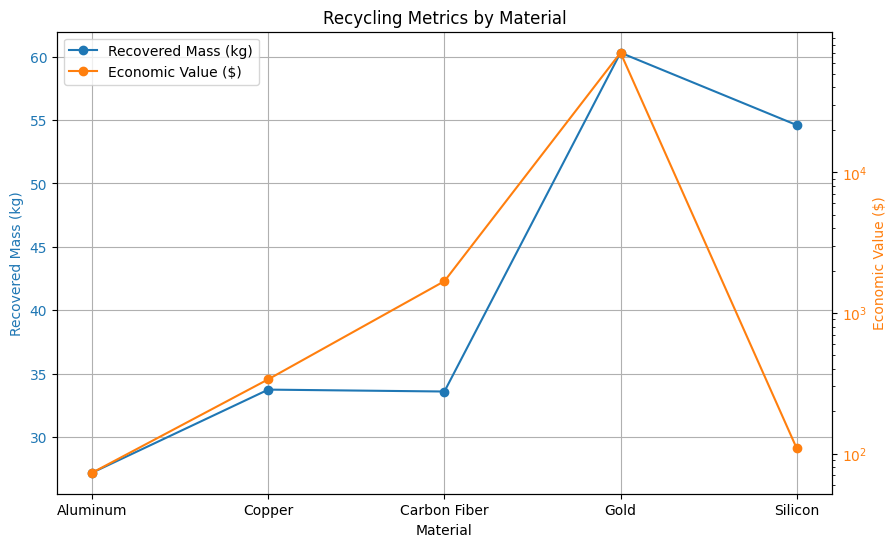

In [ ]:
# 🚀 Recycling & Resource Mapping Module - Google Colab Version

import pandas as pd
import matplotlib.pyplot as plt
import requests
import time
from datetime import datetime
import os
from groq import Groq # Import the Groq class
from google.colab import userdata # Import userdata to get the API key

# Assuming the Gemini model is already initialized as 'model' in a previous cell
# If not, you'll need to add code here to initialize it:
# import google.generativeai as genai
# from google.colab import userdata
# GOOGLE_API_KEY=userdata.get('GOOGLE_API_KEY') # Or your preferred method
# genai.configure(api_key=GOOGLE_API_KEY)
# model = genai.GenerativeModel('gemini-1.5-flash-latest') # Or your preferred model

# Get the Groq API key from Colab userdata
try:
    GROQ_API_KEY = userdata.get('GROQ_API_KEY')
except userdata.SecretNotFoundError:
    print("Error: GROQ_API_KEY not found in Colab secrets. Please add it.")
    GROQ_API_KEY = None # Set to None if key is not found


# === Material mapping with fallback values ===
material_mapping = {
    "Aluminum": {
        "end_products": ["Fuel tank shells", "Spacecraft panels"],
        "recovery_efficiency": 0.8,
        "earth_value": 2.69, # Updated price
        "fallback_value_usd_per_kg": 2.69, # Updated fallback
        "shelf_life": 15,
    },
    "Copper": {
        "end_products": ["Wiring", "Circuitry"],
        "recovery_efficiency": 0.75,
        "earth_value": 10.00, # Updated price
        "fallback_value_usd_per_kg": 10.00, # Updated fallback
        "shelf_life": 20,
    },
    "Carbon Fiber": { # Added Carbon Fiber
        "end_products": ["Structural panels"],
        "recovery_efficiency": 0.6,
        "earth_value": 50.00, # Provided price
        "fallback_value_usd_per_kg": 50.00, # Provided price as fallback
        "shelf_life": 25,
    },
    "Gold": {
        "end_products": ["Electronics coatings"],
        "recovery_efficiency": 0.9,
        "earth_value": 117000.00, # Updated price
        "fallback_value_usd_per_kg": 1170.00, # Updated fallback - corrected to a more realistic fallback
        "shelf_life": 30,
    },
    "Silicon": { # Added Silicon
        "end_products": ["Semiconductors", "Solar panels"],
        "recovery_efficiency": 0.7,
        "earth_value": 2.00, # Example price
        "fallback_value_usd_per_kg": 2.00, # Example fallback
        "shelf_life": 10,
    }
}


# === Function to get price (using fallback values) ===
def get_live_price(material, simulate=True): # Always simulate as other APIs are removed
    # Always use fallback prices
    return material_mapping[material]["fallback_value_usd_per_kg"]


# === API call for real-time end products (using Groq) ===
def get_real_time_end_products(material, recovered_mass, simulate=False): # Set simulate to False
    if simulate or GROQ_API_KEY is None: # Add check for API key
        # Fallback to mock data if simulating or if Groq call fails
        mock_end_products = {
            "Aluminum": ["Satellite chassis", "Fuel tanks"],
            "Copper": ["High-conductivity wiring", "Microelectronics"],
            "Carbon Fiber": ["Heat shields", "Lightweight panels"],
            "Gold": ["Precision circuits", "Reflective coatings"],
            "Silicon": ["Computer chips", "Solar cells"]
        }
        if GROQ_API_KEY is None:
             print("Using fallback end products because GROQ_API_KEY is not set.")
        return mock_end_products.get(material, material_mapping[material]["end_products"])

    try:
        # Initialize Groq client using the API key
        client = Groq(api_key=GROQ_API_KEY)


        prompt = f"Given that you have approximately {recovered_mass:.2f} kg of recovered {material}, provide a list of possible end products with a short description for each. Format the output as a comma-separated list of 'Product: Description'." # Modified prompt for Groq

        chat_completion = client.chat.completions.create(
            messages=[
                {
                    "role": "user",
                    "content": prompt,
                }
            ],
            model="llama-3.1-8b-instant", # Using a suitable Groq model
        )

        if chat_completion.choices and chat_completion.choices[0].message.content:
            response_text = chat_completion.choices[0].message.content
            # Assuming the response is a comma-separated string of "Product: Description"
            # Splitting the string and cleaning up whitespace
            products = [p.strip() for p in response_text.split(',') if p.strip()]
            return products
        else:
            print(f"Groq returned no text for {material} with mass {recovered_mass:.2f} kg. Using fallback end products.")
            return material_mapping[material]["end_products"]

    except Exception as e:
        print(f"Error fetching end products from Groq for {material} with mass {recovered_mass:.2f} kg: {e}")
        # Fallback to default end products in case of API error
        return material_mapping[material]["end_products"]


# === API call for real-time shelf life (simulated) ===
def get_real_time_shelf_life(material, simulate=True): # Still simulating shelf life
    if simulate:
        mock_shelf_life = {
            "Aluminum": 18,
            "Copper": 22,
            "Carbon Fiber": 28,
            "Gold": 35,
            "Silicon": 12
        }
        return mock_shelf_life.get(material, material_mapping[material]["shelf_life"])

    return material_mapping[material]["shelf_life"]

# === Suggest products dynamically ===
def suggest_products(material, recovered_mass, real_time_products):
    # If real_time_products is a list (from Groq), use it directly for joining
    if isinstance(real_time_products, list) and real_time_products:
        return real_time_products
    elif recovered_mass > 100:
        return material_mapping[material]["end_products"]
    else:
        return [f"Small-scale {p}" for p in material_mapping[material]["end_products"]]

# === Define test inputs (instead of input()) ===
# You can edit these numbers or turn them into sliders with ipywidgets
# composition_data = {
#     "Aluminum": 500,   # kg
# #     "Copper": 200,
# #     "Carbon Fiber": 100,
# #     "Gold": 50
# # }

# === Input from user ===
def get_composition_from_input():
    composition = {}
    print("Please enter the remaining mass (kg) for each material:")
    for material in material_mapping.keys():
        while True:
            try:
                mass = float(input(f"{material} (kg): "))
                if mass >= 0:
                    composition[material] = mass
                    break
                else:
                    print("Mass cannot be negative. Please enter a non-negative number.")
            except ValueError:
                print("Invalid input. Please enter a numeric value.")
    return composition


# === Main workflow ===
composition_data = get_composition_from_input()

results = []
for material, mass in composition_data.items():
    if material in material_mapping:
        mapping = material_mapping[material]
        # Set simulate=False to attempt real API call (requires valid key)
        live_price = get_live_price(material, simulate=True) # Always simulate prices


        recovered_mass = mass * mapping["recovery_efficiency"]
        economic_value = recovered_mass * live_price

        # Set simulate=False to attempt real API call (requires Groq client initialized)
        real_time_end_products = get_real_time_end_products(material, recovered_mass, simulate=False) # Use Groq for end products
        real_time_shelf_life = get_real_time_shelf_life(material, simulate=True) # Still simulating shelf life for now

        product_suggestions = suggest_products(material, recovered_mass, real_time_end_products)

        # Clean up the product suggestions string - adjust based on Groq's new output format
        # If Groq returns a single string description, the cleaning might need adjustment.
        # Assuming it might still have some formatting characters.
        cleaned_product_suggestions = ", ".join([str(p).replace('\n', '').replace('*', '').strip() for p in product_suggestions])


        shelf_life = real_time_shelf_life if real_time_shelf_life is not None else mapping["shelf_life"]

        results.append({
            "Material": material,
            "Remaining Mass (kg)": mass,
            "Recovered Mass (kg)": round(recovered_mass, 2),
            "Live Price (USD/kg)": round(live_price, 2),
            "Suggested End Products": cleaned_product_suggestions,
            "Economic Value ($)": round(economic_value, 2),
            "Shelf Life (years)": shelf_life
        })

df = pd.DataFrame(results)

# === Dashboard Outputs ===
print("\n🚀 Real-Time Recycled Material Dashboard:\n")
# Set pandas display options to show full column content
pd.set_option('display.max_colwidth', None)
display(df)  # Colab shows nice tables with display()

# Export results
df.to_csv("recycling_dashboard.csv", index=False)

# === Plots - Line Graph with Secondary Y-axis ===
plt.figure(figsize=(10, 6))

# Plot Recovered Mass on the primary y-axis
ax1 = plt.gca()
line1 = ax1.plot(df['Material'], df['Recovered Mass (kg)'], marker='o', label='Recovered Mass (kg)', color='tab:blue')
ax1.set_xlabel('Material')
ax1.set_ylabel('Recovered Mass (kg)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(True)

# Create a secondary y-axis for Economic Value with logarithmic scale
ax2 = ax1.twinx()
line2 = ax2.plot(df['Material'], df['Economic Value ($)'], marker='o', label='Economic Value ($)', color='tab:orange')
ax2.set_ylabel('Economic Value ($)', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:orange') # Corrected typo here
ax2.set_yscale('log') # Set y-axis to logarithmic scale

# Add title and legend
plt.title('Recycling Metrics by Material')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper left')

plt.show()

In [ ]:
from google.colab import userdata

# Retrieve the Groq API key from Colab Secrets
# Make sure you have added GROQ_API_KEY to your Colab Secrets
try:
    GROQ_API_KEY = userdata.get('GROQ_API_KEY')
    print("Groq API key retrieved successfully.")
except userdata.SecretNotFoundError:
    print("Error: GROQ_API_KEY not found in Colab secrets. Please add it.")
    GROQ_API_KEY = None # Set to None if key is not found

Groq API key retrieved successfully.


In [ ]:
!pip install groq